# Example for running model inference on generated coarse graphs

In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

# install hydronet or add the path to the repo here
import sys
sys.path.insert(0, '/people/pope044/Exalearn/hydronet')

# MPNN
from tensorflow.keras.models import load_model
from hydronet.mpnn.inference import run_inference
from hydronet.mpnn.layers import custom_objects
from hydronet.importing import create_inputs_from_nx

# graph utils
import sys
sys.path.insert(0,'/qfs/projects/ecp_exalearn/designs/graph_RL')
from utils import metrics, randomg

2022-01-21 13:38:53.746508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### load the trained model

In [3]:

model_path = 'train-keras/random_plus_dbtest'
model = load_model(op.join(model_path,'best_model.h5'), custom_objects=custom_objects)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-01-21 13:39:25.933465: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-21 13:39:25.994373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-01-21 13:39:25.995687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-01-21 13:39:25.995736: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-21 13:39:26.026749: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

### generate random graphs and compute metrics + MPNN energy

In [2]:
def gen_graph(n_waters):
    return randomg.generate_random_graph(n_waters, bidirectional=True)

In [4]:
n_waters=10
n_samples=1000
cols=['trimers', 'tetramers', 'pentamers', 'hexamers', 'shortest_path', 'wiener']#, 'mpnn_energy']

with Pool(12) as p:  
    graphs = p.map(gen_graph, [n_waters]*n_samples)
    mets = p.map(metrics.compute_metrics, graphs)

# create dataframe of metrics and graphs
res = np.array(mets, dtype=object).T
df = pd.DataFrame({cols[i]: res[i] for i in range(len(cols))})
df['graph']=graphs
df['edges']=df['graph'].apply(lambda G: G.number_of_edges())
df['mean_degree']=df['graph'].apply(lambda G: sum(d for n, d in G.degree()) / float(len(G))) #G.in_degree()

# collect MPNN energies
energies=[]
for i in range(len(df)):
    try:
        energies.append(run_inference(model, df.iloc[i].graph))
    except:
        energies.append(0)
df['MPNN_energy']=energies

# save to pickle
df.to_pickle(op.join(model_path, f'W{n_waters}_random_graph_inference.pkl'))

df.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,graph
0,0,2,0,0,2.4,108,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
1,1,1,4,0,2.02222,91,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
2,0,0,0,0,3.24444,146,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
3,2,1,0,0,2.55556,115,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
4,3,0,0,0,2.6,117,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"


### generate linear graphs and compute metrics + MPNN energy

In [143]:
def generate_linear_graph(n_waters, bidirectional=True):
    # create adjacency matrix for linear graph
    A = np.zeros((n_waters,n_waters))
    rng = np.arange(n_waters-1)
    A[rng, rng+1] = 1
    rng = np.arange(n_waters)
    A[rng, rng-1] = 1
    A[0, n_waters-1] = 0

    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph)
 
    # remove edges that go in both directions
    for edge in G.to_undirected(reciprocal=True).edges:
        edge = list(edge)
        np.random.shuffle(edge)
        G.remove_edge(edge[0],edge[1])

        
    nx.set_node_attributes(G, 'O', "label")
    nx.set_edge_attributes(G, 'donate', "label")
    
    # for input into MPNN
    if bidirectional:
        # add accept edges in the reverse direction
        G.add_edges_from(np.array(G.edges)[:,::-1], label='accept')
    return G

In [141]:
g=generate_linear(10)
run_inference(model, g)

-39.018745

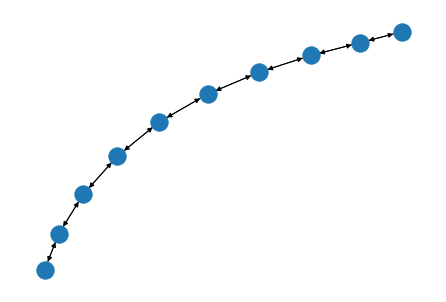

In [142]:
nx.draw_spring(g)

In [144]:
n_waters=10
n_samples=1000
cols=['trimers', 'tetramers', 'pentamers', 'hexamers', 'shortest_path', 'wiener']#, 'mpnn_energy']

with Pool(12) as p:  
    graphs = p.map(generate_linear_graph, [n_waters]*n_samples)
    mets = p.map(metrics.compute_metrics, graphs)

# create dataframe of metrics and graphs
res = np.array(mets, dtype=object).T
df = pd.DataFrame({cols[i]: res[i] for i in range(len(cols))})
df['graph']=graphs
df['edges']=df['graph'].apply(lambda G: G.number_of_edges())
df['mean_degree']=df['graph'].apply(lambda G: sum(d for n, d in G.degree()) / float(len(G))) #G.in_degree()

# collect MPNN energies
energies=[]
for i in range(len(df)):
    try:
        energies.append(run_inference(model, df.iloc[i].graph))
    except:
        energies.append(0)
df['MPNN_energy']=energies

# save to pickle
df.to_pickle(op.join(model_path, f'W{n_waters}_linear_inference.pkl'))

df.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,graph,edges,mean_degree,MPNN_energy
0,0,0,0,0,3.66667,165,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",18,3.6,-43.325947
1,0,0,0,0,3.66667,165,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",18,3.6,-37.633316
2,0,0,0,0,3.66667,165,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",18,3.6,-43.539463
3,0,0,0,0,3.66667,165,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",18,3.6,-37.937000
4,0,0,0,0,3.66667,165,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",18,3.6,-39.788368


### compare linear vs no linear graphs for our trained MPNN

In [146]:
df=pd.read_pickle(op.join(model_path, f'W{n_waters}_linear_inference.pkl'))
dd=pd.read_pickle(op.join(model_path, f'W{n_waters}_random_graph_inference.pkl'))

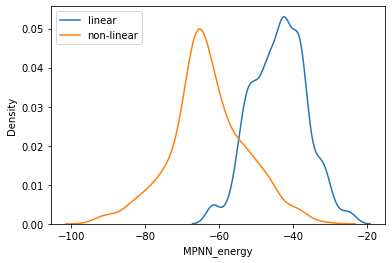

In [149]:
sns.kdeplot(data=df, x='MPNN_energy', label='linear')
sns.kdeplot(data=dd.loc[dd.MPNN_energy!=0], x='MPNN_energy', label='non-linear')
plt.legend(loc='upper left')
plt.show()